# Embeddings
- [gensim](https://radimrehurek.com/gensim/auto_examples/tutorials/run_annoy.html?highlight=load%20word2vec%20txt#work-with-google-s-word2vec-files) - **why do I need it????**
- [tokenizer](https://github.com/google/sentencepiece/blob/master/python/README.md)


## Load data (separate dataset)
- the 2008-2016 dataset 
- python language

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sentencepiece as spm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks 
from tensorflow.keras import optimizers

In [2]:
df = pd.read_csv("py_df.csv")
df = df.drop(columns=["round", "task", "solution", "file", "full_path", "Unnamed: 0.1", "Unnamed: 0", "lang"])

- Let's collect `20` users with avg amount of files, which is around 100
(enough files, but their difference amount is not sufficient)

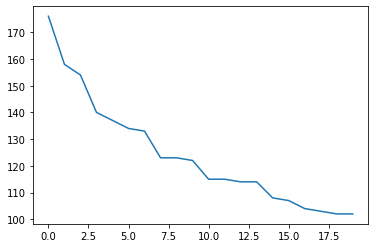

In [3]:
plt.plot(np.array(df.username.value_counts())[:20])

In [4]:
users = df.username.value_counts()[:20].index
data_for_users = df[df.username.isin(users)]
data_for_users.head()

,year,username,flines
0,2008,mth,"#!/usr/bin/env python\n \n def comb(a, b):\n \..."
6,2008,RalfKistner,"#!/usr/bin/python\n \n fin = open(""d.in"", ""r"")..."
7,2008,RalfKistner,"#!/usr/bin/python\n \n fin = open(""b.in"", ""r"")..."
8,2008,RalfKistner,"#!/usr/bin/python\n \n fin = open(""b.in"", ""r"")..."
21,2008,lidaobing,import sys\n \n def getints(ifile):\n retu...


- Let's find avg file length (in chars)

In [5]:
data_for_users.flines.apply(lambda x: len(str(x))).describe()

count     2484.000000
mean      1836.997585
std       2096.710016
min        129.000000
25%        719.000000
50%       1282.000000
75%       2094.000000
max      38876.000000
Name: flines, dtype: float64

- let's find avg file length (in lines)

In [6]:
data_for_users["n_lines"] = data_for_users.flines.apply(lambda x: str(x).count("\n"))
data_for_users["n_lines"].describe()

/Users/alinabogdanova/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


count    2484.000000
mean       68.179147
std        61.019554
min         0.000000
25%        30.000000
50%        52.000000
75%        83.000000
max       615.000000
Name: n_lines, dtype: float64

- remove files with amount of lines not in `[30, 100]` -> decrease on `1/2`

In [7]:
data_for_users = data_for_users[(data_for_users.n_lines>=30)&(data_for_users.n_lines<=100)]
data_for_users.n_lines.describe()

count    1437.000000
mean       57.100209
std        18.531002
min        30.000000
25%        41.000000
50%        55.000000
75%        72.000000
max       100.000000
Name: n_lines, dtype: float64

- remove authors with small amount of files

In [8]:
data_for_users.username.value_counts().describe()

count     20.000000
mean      71.850000
std       26.962498
min       26.000000
25%       60.000000
50%       66.500000
75%       86.000000
max      135.000000
Name: username, dtype: float64

In [9]:
tobe_saved = data_for_users.username.value_counts()[:75].index
data_for_users = data_for_users[data_for_users.username.isin(tobe_saved)]
data_for_users

,year,username,flines,n_lines
0,2008,mth,"#!/usr/bin/env python\n \n def comb(a, b):\n \...",41
6,2008,RalfKistner,"#!/usr/bin/python\n \n fin = open(""d.in"", ""r"")...",50
21,2008,lidaobing,import sys\n \n def getints(ifile):\n retu...,48
23,2008,lidaobing,import sys\n import psyco\n psyco.full()\n imp...,85
28,2008,gizzywump,#!/usr/bin/env python\n \n import sys\n \n CAC...,38
...,...,...,...,...
154546,2016,kawasaki,import itertools\n \n T = int(raw_input())\n f...,40
155179,2016,Nooodles,### Google code jam 2016\n ### Online round 1C...,78
155180,2016,Nooodles,### Google code jam 2016\n ### Online round 1C...,35
155181,2016,Nooodles,### Google code jam 2016\n ### Online round 1C...,35


- let's find avg file length (in chars)

In [10]:
data_for_users["n_chars"] = data_for_users.flines.apply(lambda x: len(str(x)))
(data_for_users.n_chars/data_for_users.n_lines).describe()

count    1437.000000
mean       24.957079
std         5.429807
min        13.890625
25%        21.911765
50%        24.265625
75%        27.000000
max       101.256410
dtype: float64

- suspicious max value let's drop evetyrhing, highter then `102` and look, what's left

In [11]:
data_for_users["chars_per_line"] = data_for_users.n_chars/data_for_users.n_lines
data_for_users = data_for_users[data_for_users.chars_per_line<102]

- only two files were rmoved

In [12]:
data_for_users

,year,username,flines,n_lines,n_chars,chars_per_line
0,2008,mth,"#!/usr/bin/env python\n \n def comb(a, b):\n \...",41,870,21.219512
6,2008,RalfKistner,"#!/usr/bin/python\n \n fin = open(""d.in"", ""r"")...",50,1040,20.800000
21,2008,lidaobing,import sys\n \n def getints(ifile):\n retu...,48,931,19.395833
23,2008,lidaobing,import sys\n import psyco\n psyco.full()\n imp...,85,1911,22.482353
28,2008,gizzywump,#!/usr/bin/env python\n \n import sys\n \n CAC...,38,885,23.289474
...,...,...,...,...,...,...
154546,2016,kawasaki,import itertools\n \n T = int(raw_input())\n f...,40,1580,39.500000
155179,2016,Nooodles,### Google code jam 2016\n ### Online round 1C...,78,1763,22.602564
155180,2016,Nooodles,### Google code jam 2016\n ### Online round 1C...,35,723,20.657143
155181,2016,Nooodles,### Google code jam 2016\n ### Online round 1C...,35,723,20.657143


In [13]:
data_for_users.describe()

,year,n_lines,n_chars,chars_per_line
count,1437.000000,1437.000000,1437.000000,1437.000000
mean,2012.295059,57.100209,1429.414057,24.957079
std,2.431928,18.531002,565.805301,5.429807
min,2008.000000,30.000000,508.000000,13.890625
25%,2010.000000,41.000000,1009.000000,21.911765
50%,2012.000000,55.000000,1340.000000,24.265625
75%,2014.000000,72.000000,1738.000000,27.000000
max,2016.000000,100.000000,3970.000000,101.256410


- let's leave the dataset, as it is for now

In [14]:
df = data_for_users

## Embedding

In [15]:
sp = spm.SentencePieceProcessor(model_file='embd/sentencepiece_bpe.model')
sp.encode('\tarr = [int(x) for x in str.split()]')

[6682, 14, 127, 184, 96091, 96097, 96090, 115, 419, 57, 420, 96084, 1300, 5382]

In [16]:
print(sp.decode(sp.encode('    arr = [int(x) for x in str.split()]')))

arr = [int(x) for x in str.split()]


- **we loose layout features!**

In [17]:
df.index = np.arange(len(df))
df["n_tokens"] = df.flines.apply(lambda x: len(sp.encode(x)))
df.describe()

,year,n_lines,n_chars,chars_per_line,n_tokens
count,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000
mean,2012.295059,57.100209,1429.414057,24.957079,368.106472
std,2.431928,18.531002,565.805301,5.429807,144.162471
min,2008.000000,30.000000,508.000000,13.890625,134.000000
25%,2010.000000,41.000000,1009.000000,21.911765,262.000000
50%,2012.000000,55.000000,1340.000000,24.265625,337.000000
75%,2014.000000,72.000000,1738.000000,27.000000,451.000000
max,2016.000000,100.000000,3970.000000,101.256410,1323.000000


- rm files with amount of tokens less greater, then 500

In [18]:
df = df[df.n_tokens<=500]
df.describe()

,year,n_lines,n_chars,chars_per_line,n_tokens
count,1196.000000,1196.000000,1196.000000,1196.000000,1196.000000
mean,2012.272575,52.198997,1253.263378,24.169510,319.735786
std,2.413203,15.470816,390.691669,4.068160,88.911947
min,2008.000000,30.000000,508.000000,13.890625,134.000000
25%,2010.000000,39.000000,944.750000,21.595238,249.750000
50%,2012.000000,51.000000,1236.000000,23.588781,316.000000
75%,2014.000000,61.000000,1521.000000,26.327869,383.000000
max,2016.000000,99.000000,2966.000000,42.854545,500.000000


-  let's hope, that `min = 21` is ok

In [19]:
df.username.value_counts()

EricStansifer    124
lidaobing         98
RalfKistner       84
gizzywump         75
kmod              71
mth               66
Martial           64
Sp3000            63
Fizu              58
raja.baz          58
linguo            57
zibada            55
zli               52
Nooodles          51
kawasaki          50
graygrass         46
eMBe              42
bigOnion          32
kusano            29
festony           21
Name: username, dtype: int64

In [20]:
df["tokens"] = df.flines.apply(lambda x: sp.encode(x))

/Users/alinabogdanova/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
df.head()

,year,username,flines,n_lines,n_chars,chars_per_line,n_tokens,tokens
0,2008,mth,"#!/usr/bin/env python\n \n def comb(a, b):\n \...",41,870,21.219512,297,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 6..."
1,2008,RalfKistner,"#!/usr/bin/python\n \n fin = open(""d.in"", ""r"")...",50,1040,20.800000,335,"[3238, 2785, 96124, 1119, 96124, 1796, 3014, 1..."
2,2008,lidaobing,import sys\n \n def getints(ifile):\n retu...,48,931,19.395833,250,"[138, 1149, 63, 398, 7686, 96091, 96073, 252, ..."
3,2008,lidaobing,import sys\n import psyco\n psyco.full()\n imp...,85,1911,22.482353,480,"[138, 1149, 138, 20653, 62, 20653, 62, 96084, ..."
4,2008,gizzywump,#!/usr/bin/env python\n \n import sys\n \n CAC...,38,885,23.289474,285,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."


In [22]:
dataset = df[["username", "tokens"]]

In [23]:
dataset

,username,tokens
0,mth,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 6..."
1,RalfKistner,"[3238, 2785, 96124, 1119, 96124, 1796, 3014, 1..."
2,lidaobing,"[138, 1149, 63, 398, 7686, 96091, 96073, 252, ..."
3,lidaobing,"[138, 1149, 138, 20653, 62, 20653, 62, 96084, ..."
4,gizzywump,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
...,...,...
1432,kawasaki,"[138, 6912, 111, 14, 655, 96091, 1032, 96077, ..."
1433,Nooodles,"[5059, 9337, 1174, 1250, 144, 9647, 5059, 4474..."
1434,Nooodles,"[5059, 9337, 1174, 1250, 144, 9647, 5059, 4474..."
1435,Nooodles,"[5059, 9337, 1174, 1250, 144, 9647, 5059, 4474..."


## Load data
Lib selected - tensorflow + keras

### Some small notes for future
Tensorflow supports python 3.8 as max version. The issue arises on latest Ubuntu/max os-es, when the default python version is 3.9.

What was done on MAC-OS-Big-Sur to solve that issue.
- [pyenv](https://github.com/pyenv/pyenv) installed
```bash
>> brew update
>> brew install pyenv
...
```
- python 3.7 installation
```
>> brew install python@3.7
```
- pyenv added python 3.7
```
>> pyenv install 3.7.10
>> pyenv loacal 3.7.10
```
- create [myenv](https://www.tensorflow.org/install/pip#2.-create-a-virtual-environment-recommended)
```
>> python3.7 -m venv myenv
>> source myenv/bin/activate.fish
```
- solution of the final problem - **UPGRADE PIP**
- install tensorflow
```
(myenv)>> pip install --upgrade tensorflow
```

In [24]:
le = LabelEncoder()
dataset.username = le.fit_transform(dataset.username)

/Users/alinabogdanova/Documents/workspace/research/myenv/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [25]:
# shuffle dataset
dataset = dataset.sample(frac = 1) 
dataset

,username,tokens
291,2,"[138, 1149, 115, 2082, 96077, 759, 57, 1181, 2..."
962,9,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
571,14,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
835,0,"[3238, 2785, 96124, 1119, 96124, 1796, 96116, ..."
143,10,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 4..."
...,...,...
1214,0,"[138, 1149, 20094, 14, 159, 9379, 14, 159, 63,..."
109,7,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
119,0,"[3238, 2785, 96124, 1119, 96124, 1796, 156, 41..."
1430,11,"[30607, 96106, 14, 24, 61531, 55606, 96086, 11..."


In [26]:
def rsh(x):
    arr = np.array(x)
    arr.resize(500)
    return list(arr)

dataset.tokens = dataset.tokens.apply(rsh)

In [27]:
dataset

,username,tokens
291,2,"[138, 1149, 115, 2082, 96077, 759, 57, 1181, 2..."
962,9,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
571,14,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
835,0,"[3238, 2785, 96124, 1119, 96124, 1796, 96116, ..."
143,10,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 4..."
...,...,...
1214,0,"[138, 1149, 20094, 14, 159, 9379, 14, 159, 63,..."
109,7,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
119,0,"[3238, 2785, 96124, 1119, 96124, 1796, 156, 41..."
1430,11,"[30607, 96106, 14, 24, 61531, 55606, 96086, 11..."


In [28]:
X = dataset.tokens.values
X = np.array(list(X))
X.shape

(1196, 500)

In [29]:
X = X.reshape((-1, 500, 1))
y = np.array(dataset.username)

ohe = OneHotEncoder()
y = ohe.fit_transform(y.reshape(-1, 1))
y = y.toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape

(897, 500, 1)

### Structure of the model
1. CNN:
- ks = 50 (function - level)
- ks = 10 (line2 - level)
- ks = 5 (lene - level)
2. Linear ReLU 
3. softmax 75

> important note `tanh` activation increases accuracy from 11% to 60% ontraining (50% of test accuracy)
>
> `linear` function reaches up to 61% of test accuracy

In [30]:
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(150, 10, activation="linear")) # a few lines
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 491, 150)          1650      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 61, 150)           0         
_________________________________________________________________
flatten (Flatten)            (None, 9150)              0         
_________________________________________________________________
dropout (Dropout)            (None, 9150)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                585664    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1

In [31]:
optimizer = optimizers.Adam(0.1)
lr_schedule = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_delta=0.000001, verbouse=1)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [32]:
epochs = 100
batch_size = 20
history = model.fit(x=X_train, y=y_train, epochs = epochs, 
                    validation_data = (X_test,y_test),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    verbose=2, 
                    callbacks=[lr_schedule])

Epoch 1/100
44/44 - 2s - loss: 17090558.0000 - accuracy: 0.0893 - val_loss: 10183527.0000 - val_accuracy: 0.1773
Epoch 2/100
44/44 - 1s - loss: 18333826.0000 - accuracy: 0.1634 - val_loss: 12428410.0000 - val_accuracy: 0.2508
Epoch 3/100
44/44 - 1s - loss: 36268492.0000 - accuracy: 0.2026 - val_loss: 56828760.0000 - val_accuracy: 0.2007
Epoch 4/100
44/44 - 1s - loss: 93090848.0000 - accuracy: 0.2244 - val_loss: 111342640.0000 - val_accuracy: 0.2642
Epoch 5/100
44/44 - 1s - loss: 154830640.0000 - accuracy: 0.2375 - val_loss: 103895304.0000 - val_accuracy: 0.3813
Epoch 6/100
44/44 - 1s - loss: 177690608.0000 - accuracy: 0.2854 - val_loss: 125560128.0000 - val_accuracy: 0.4214
Epoch 7/100
44/44 - 1s - loss: 206634064.0000 - accuracy: 0.3519 - val_loss: 201900976.0000 - val_accuracy: 0.4147
Epoch 8/100
44/44 - 0s - loss: 243565952.0000 - accuracy: 0.3965 - val_loss: 200778560.0000 - val_accuracy: 0.5084
Epoch 9/100
44/44 - 1s - loss: 237012704.0000 - accuracy: 0.4760 - val_loss: 210704912.

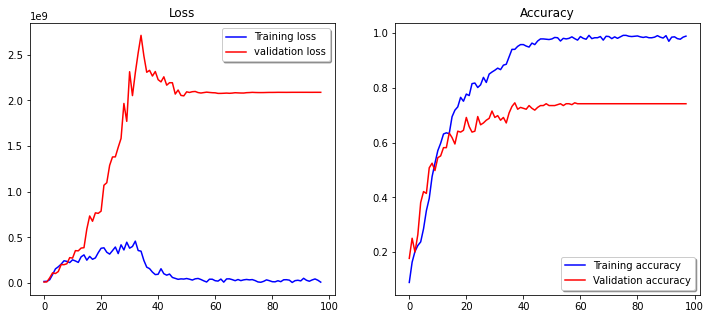

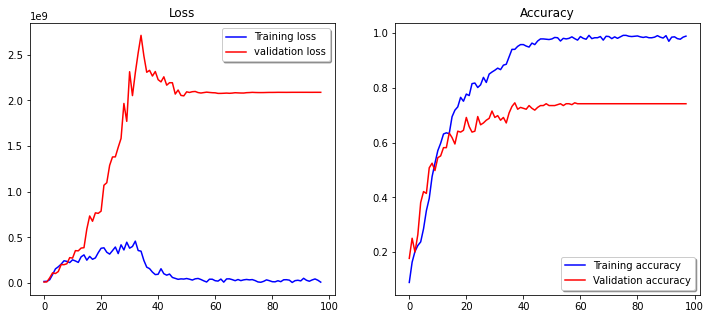

In [33]:
def plot_training(history):
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.title("Loss")
    plt.plot(history.history['loss'], color='b', label="Training loss")
    plt.plot(history.history['val_loss'], color='r', label="validation loss")
    plt.legend(loc='best', shadow=True)

    plt.subplot(122)
    plt.title("Accuracy")
    plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
    plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    plt.legend(loc='best', shadow=True)
    return fig

plot_training(history)

#### 68.77% test accuracy

```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(100, 32, activation="linear"))
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### up to 70% (converges to 69.044) test accuracy
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(100, 16, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### converges to 70.01% test accuracy
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(100, 8, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 72% of test accuracy
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1))) 
model.add(layers.Conv1D(150, 8, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=6))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### confident 73%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(128, 16, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### up to 74%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1))) 
model.add(layers.Conv1D(128, 16, activation="linear", strides=2)) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### converges to 75% test accuracy (up to 77%)
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(150, 10, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

- Also the structures with 2 Convolutional layers were tested (up to 50% accuracy)
- Avg Pooling works poarly due to the fact, that the initial data is not normalized

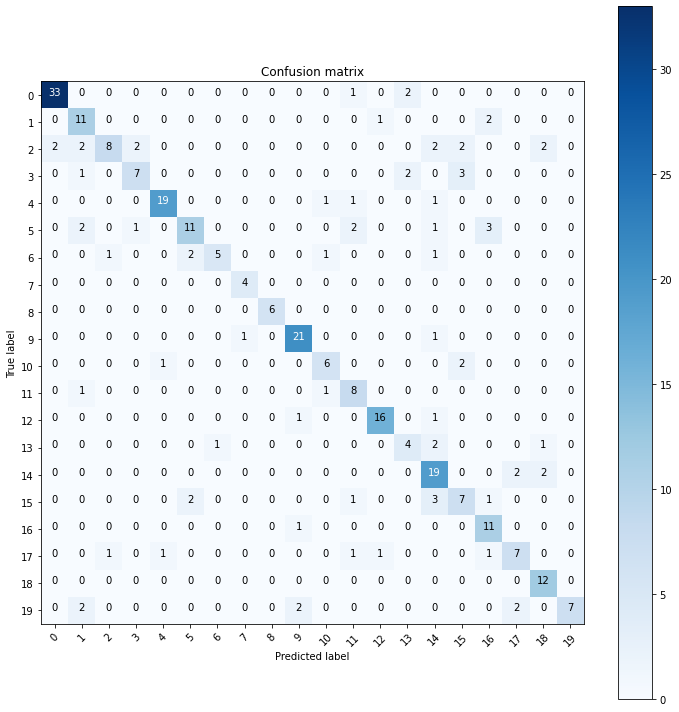

In [34]:
from sklearn.metrics import confusion_matrix
import itertools

def plt_conf_matrix(cm, classes):
    cmap=plt.cm.Blues
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
     

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
plt_conf_matrix(confusion_mtx, classes = range(20))

I don't know, what are these ebbeddings, but...

## Let's apply normalization
(thus `relu`, `than` and other activations may be used)

In [35]:
from sklearn.preprocessing import StandardScaler

In [36]:
print(X.min(), X.mean(), X.max())

0 18547.634802675584 99263


As it can be seen, the avg value is far from it's maximum value, thus it is more readonable to apply Standard Scaling

In [37]:
ss = StandardScaler()
X = X.reshape((-1, 500))
X = ss.fit_transform(X)
X = X.reshape((-1, 500, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape

(897, 500, 1)

In [49]:
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(64, 16, activation="tanh"))
model.add(layers.AveragePooling1D(pool_size=8))
model.add(layers.Conv1D(32, 8, activation="linear")) 
model.add(layers.AveragePooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 485, 64)           1088      
_________________________________________________________________
average_pooling1d (AveragePo (None, 60, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 53, 32)            16416     
_________________________________________________________________
average_pooling1d_1 (Average (None, 13, 32)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 416)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 416)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

In [50]:
optimizer = optimizers.Adam(0.01)
lr_schedule = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_delta=0.000001, verbouse=1)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [51]:
epochs = 100
batch_size = 20
history = model.fit(x=X_train, y=y_train, epochs = epochs, 
                    validation_data = (X_test,y_test),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    verbose=2, 
                    callbacks=[lr_schedule])

Epoch 1/100
44/44 - 1s - loss: 3.2079 - accuracy: 0.0686 - val_loss: 3.2081 - val_accuracy: 0.1070
Epoch 2/100
44/44 - 0s - loss: 3.0270 - accuracy: 0.1264 - val_loss: 2.7933 - val_accuracy: 0.1438
Epoch 3/100
44/44 - 0s - loss: 2.8866 - accuracy: 0.1699 - val_loss: 2.7427 - val_accuracy: 0.1605
Epoch 4/100
44/44 - 0s - loss: 2.8525 - accuracy: 0.1808 - val_loss: 2.6199 - val_accuracy: 0.2207
Epoch 5/100
44/44 - 0s - loss: 2.7248 - accuracy: 0.2157 - val_loss: 2.5843 - val_accuracy: 0.2274
Epoch 6/100
44/44 - 0s - loss: 2.7902 - accuracy: 0.2070 - val_loss: 2.7273 - val_accuracy: 0.2241
Epoch 7/100
44/44 - 1s - loss: 2.6360 - accuracy: 0.2266 - val_loss: 2.4587 - val_accuracy: 0.2709
Epoch 8/100
44/44 - 0s - loss: 2.5049 - accuracy: 0.2571 - val_loss: 2.4241 - val_accuracy: 0.3144
Epoch 9/100
44/44 - 0s - loss: 2.7401 - accuracy: 0.2200 - val_loss: 2.5265 - val_accuracy: 0.2809
Epoch 10/100
44/44 - 0s - loss: 2.5818 - accuracy: 0.2680 - val_loss: 2.5689 - val_accuracy: 0.2375
Epoch 11/

#### 75% accuracy (previous model)
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(150, 10, activation="linear")) # a few lines
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 74%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(128, 16, activation="tanh")) # a few lines
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 63%, less overfitting
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(64, 16, activation="tanh"))
model.add(layers.Conv1D(32, 64, activation="tanh")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 75% up to 77%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(64, 16, activation="tanh"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Conv1D(32, 4, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 74%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(64, 16, activation="tanh"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Conv1D(32, 4, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```
#### 76% up to 78%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(64, 16, activation="tanh"))
model.add(layers.AveragePooling1D(pool_size=8))
model.add(layers.Conv1D(32, 8, activation="linear")) 
model.add(layers.AveragePooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### fast to 76% upt to 78%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(128, 16, activation="relu"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()

```

In [52]:
model.save('model.h5')

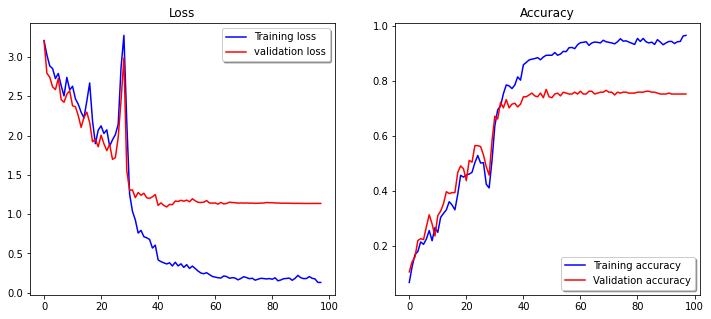

In [53]:
f = plot_training(history)

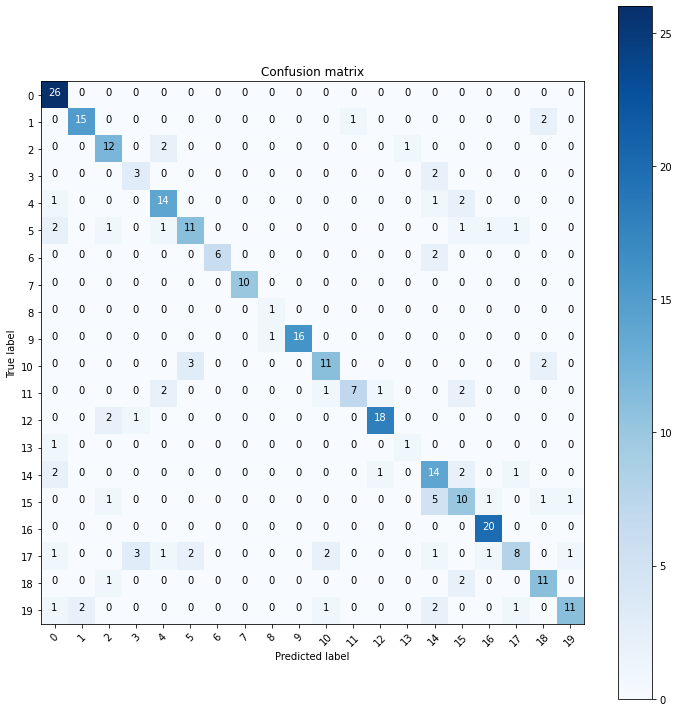

In [54]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
plt_conf_matrix(confusion_mtx, classes = range(20))